<h1>Module Description</h1>

---

The current ipynb-module contains implementation of data preparing, especially it represents functions, which extracts faces from photos. For this purpose I've used the DNN module (specifically the network based on Single Shot MultiBox Detector, designed by [Aleksandr Rybnikov](https://github.com/arrybn)) from OpenCV. You can familiarize with the [paper](https://arxiv.org/pdf/1512.02325.pdf) which fully describes this algorithm. However I gonna try to shorthand how does it work.

## Table of Contents
- [Module Description](#Module-Description)
    - [Table of Contents](#Table-of-Contents)
    - [Algorithm Shorthand](#Algorithm-Shorthand)
        - [Goal](#Goal)
            - [Photos Sample](#Photos-Sample)
        - [Underlies Algorithm](#Underlies-Algorithm)
            -[How Do Anchor Boxes Work?](#How-Do-Anchor-Boxes-Work?)
        - [The Single Shot Detector](#The-Single-Shot-Detector)
        - [Links](#Links)
    - [Impementation](#Impementation)
        - [Import Libraries](#Import-Libraries)
        - [Global Variables](#Global-Variables)
        - [Extract Faces Function](#Extract-Faces-Function)
        - [Support Functions](#Support-Functions)
        - [The Base Handling Function](#The-Base-Handling-Function)
        - [Handle Data](#Handle-Data)
        - [Recap](#Recap)
        - [Save Processed Data As Numpy Array](#Save-Processed-Data-As-Numpy-Array)
    - [Example For The Explanations](#Examples-from-explanations-above)
    
    


<h2>Algorithm Shorthand</h2>

---

<h3>Goal</h3>

So let's consider the goal, which we wanna to attain. Due to in a photo occurs a lot of redundant things, like background things (*buildings, trees, cars etc*), bodies (*yep, I remove bodies, because many girl in the [Tinder](https://tinder.com) post photos only with a face, therefore I decided to feed CNN using only with faces*.). Let's take alook at the photos which suitable for face retrieving. (At least I wanna, so that they would be)

<h4>Photos Sample</h4> 

Instagram: <a href="https://www.instagram.com/exx1dae">@exx1dae</a>

<div>
    <img src="../img/exx1dae_1.jpg" style="width:300px; height: 300px; float: left; padding: 10px; margin-top: 14px;">
    <img src="../img/exx1dae_2.jpg"  style="width:300px; height: 300px; float: left; padding: 10px;">
    <img src="../img/exx1dae_3.jpg"  style="width:300px; height: 300px; float: left; padding: 10px;">
    <img src="../img/exx1dae_4.jpg"  style="width:300px; height: 300px; float: left; padding: 10px;">
    <img src="../img/exx1dae_5.jpg"  style="width:300px; height: 300px; float: left; padding: 10px;">
    <img src="../img/exx1dae_6.jpg"  style="width:300px; height: 300px; float: left; padding: 10px;">
</div>

<h3>Underlies Algorithm</h3>

As it said in the article, **Single Shot MultiBox Detector** uses deafult boxes similar to [*anchor boxes*](https://www.mathworks.com/help/vision/ug/anchor-boxes-for-object-detection.html) in MATLAB. This method differs from other with its speed and accuracy of predictions. For instance, detectors based on aggregate channel features (ACF) or histogram of gradients (HOG) features, slides a filter over the entire image and convolute it to a higher-level matrix according feature map. The process looks like this:

![sliding_window](../img/anchorboxvsslidingwindow.png)

"*Because a convolutional neural network (CNN) can process an input image in a convolutional manner, a spatial location in the input can be related to a spatial location in the output. This convolutional correspondence means that a CNN can extract image features for an entire image at once. The extracted features can then be associated back to their location in that image. The use of anchor boxes replaces and drastically reduces the cost of the sliding window approach for extracting features from an image. Using anchor boxes, you can design efficient deep learning object detectors to encompass all three stages (detect, feature encode, and classify) of a sliding-window based object detector*."

However in Anchor Box method we use the filter, which tiled with set of predefined bounding boxes of a certain height and width. These boxes defined to capture the objects (its scale and some attributes) of a specific class, that one on which the network has been learned. Therefore the size of a default boxes based on the typical size in a training set. The network predicts the probability and other attributes, such as background, intersection over union (IoU) and offsets for every tiled anchor box. The network does not directly predict bounding boxes, but rather predicts the probabilities and refinements that correspond to the tiled anchor boxes. The network returns a unique set of predictions for every anchor box defined. The final feature map represents object detections for each class.
The filter looks like that:

![anchorbox whatis](../img/anchorbox_whatis.png)

<h4>How Do Anchor Boxes Work?</h4>

"*The position of an anchor box is determined by mapping the location of the network output back to the input image. The process is replicated for every network output. The result produces a set of tiled anchor boxes across the entire image. Each anchor box represents a specific prediction of a class.*"
Below there two anchor boxes to make two predictions per location:

![anchorbox2](../img/anchorbox2.png)

Each anchor box is tiled across the image. The number of network outputs equals the number of tiled anchor boxes. The network produces predictions for all outputs. Also, whereas the downsampling occurs, we get the localiztion error because the distance, between the tiled anchor boxes is a function of the amount of downsampling present in the CNN, therefore when we're downsampling a picture we have such problem:

![anchorboxdownsampling](../img/anchorboxdownsampling.png)

To fix this the dnn learns offset to apply to each tiled anchor box refining the anchor box position and size.

![yolo_detection](../img/yolo_detection.png)

<h3>The Single Shot Detector</h3>

In the SSD model uses the same basic principle, it adjusts boxes (by ascertain their offsets), and predicts the confidence for all object categories.

*At training time, we first match these default boxes to the ground truth boxes. For
example, we have matched two default boxes with the cat and one with the dog, which
are treated as positives and the rest as negatives. The model loss is a weighted sum
between localization loss (e.g. Smooth L1) and confidence loss (e.g. Softmax).*

![catdog](../img/catdogboxes.png)

To the base network (In the SSD the VGG-16 network appears as a base, but other networks should also produce good results) adds following key features up:

1. "<em><strong>Multi-scale feature maps for detection</strong> We add convolutional feature layers to the end of the truncated base network.These layers decrease in size progressively and allow predictions of detections at multiple scales</em>"

2. "<em><strong>Convolutional predictors for detection</strong> Each added feature layer (or optionally an existing feature layer from the base network) can produce a fixed set of detection predictions using a set of convolutional filters.</em>"

3. "<em><strong>Default boxes and aspect ratios</strong> We associate a set of default bounding boxes with
each feature map cell, for multiple feature maps at the top of the network. The default
boxes tile the feature map in a convolutional manner, so that the position of each box
relative to its corresponding cell is fixed. At each feature map cell, we predict the offsets
relative to the default box shapes in the cell, as well as the per-class scores that indicate
the presence of a class instance in each of those boxes. Specifically, for each box out of
k at a given location, we compute c class scores and the 4 offsets relative to the original
default box shape. This results in a total of \\((c + 4) \times k\\) filters that are applied around each
location in the feature map, yielding \\((c + 4)\times k \times m \times n\\) outputs for a \\(m \times n\\) feature map. Our default boxes are similar to the anchor boxes used in Faster R-CNN, however we apply them to several feature maps of different resolutions. Allowing different default box shapes in several featuremaps let us efficiently discretize the space of possible output box shapes.</em>"

**YOLO and SSD comparsion**

![YOLOSSD](../img/YOLOSSD.png)

"*Our SSD model adds several feature layers to the end of a base network, which predict
the offsets to default boxes of different scales and aspect ratios and their associated
confidences. SSD with a 300 × 300 input size significantly outperforms its 448 × 448
YOLO counterpart in accuracy on VOC2007 test while also improving the speed.*" 

<h3>Links</h3>

1. **This was a shorthand of the SSD algorithm. You can familiarize with integrall description by following the [link](https://arxiv.org/pdf/1512.02325.pdf)**

2. **Also you can see the results of face detection (extracting) from a photos represented above, by following this [link](#Examples-from-explanations-above)**

<h2>Impementation</h2>

---

<h3>Import Libraries</h3>

In [1]:
%matplotlib inline
import cv2
import sys
import numpy as np
import os
import inspect
from skimage import io
from scipy import misc
import matplotlib.pyplot as plt
from skimage.transform import resize
from IPython.display import clear_output
import pandas as pd

<h3>Global Variables</h3>

In [2]:
img_size = 256 # out image's size
faces_in_image_limit = 1 # number of people in image. We want images of single people.

<h3>Extract Faces Function</h3>

In [3]:
def extract_faces(img):
    """This function extracts a face from a photo.
    
    :param img: the image from which we wanna to derive a face.
    
    :return: np.array of an extracted face and confidence that it is a human face.
    """
    model_file = "utils/opencv_face_detector_uint8.pb"
    config_file = "utils/opencv_face_detector.pbtxt"
    
    # This network has been created for the Caffe and Tensorflow, I used the second one
    net = cv2.dnn.readNetFromTensorflow(model_file, config_file)
    
    # Returning results
    image_data_fin = []
    confidence_res = None
    
    h, w = img.shape[:2]
    
    # https://www.pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/ blob description
    # First we resize the image to 300x300 according to the pretrained weights
    # Second, the scale factor (standard deviation in the z-scoring), I do not use the scale therefore set it as 1.0
    # Third, mean-tupple of RGB [mu-Red, mu-Green, mu-Blue] 
    # Forth, indicates that swap first and last channels in 3-channel image is necessary.
    # Fifth, indicates whether image will be cropped after resize or not
    blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0, (300, 300), [104, 117, 123], False, False)
    
    # pass the blob through the network and obtain the detections and predictions
    net.setInput(blob)
    detections = net.forward()
    
    # loop over the detections
    for i in range(detections.shape[2]):
        # extract the confidence (i.e., probability) associated with the prediction
        # https://docs.opencv.org/trunk/d3/d63/classcv_1_1Mat.html
        confidence = detections[0, 0, i, 2]
        # If confidence is higher than 50% than 
        if confidence > 0.5:
            # compute the (x, y)-coordinates of the bounding box for the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x, y, x1, y1) = box.astype("int")
            # create a new image (augmented image, in the way to cut off everything except a face)
            roi_color = img[y:y1, x:x1]
            im = resize(roi_color, (img_size, img_size))
            image_data_fin.append(im)
            confidence_res = confidence
    
    # If the only one face on a photo then return it (as np.array) and confidence that it is a human face.
    if len(image_data_fin) != faces_in_image_limit:
        return [], None
    else:
        return image_data_fin, confidence_res

<h3>Support Functions</h3>

In [4]:
def print_progress(total, current, image, like_type, missing_imgs):
    """This function print progress whereas files are handling.
    
    :param total: total number of files
    :param current: current number of handled files
    :param image: an image's name
    :param like_type: the folder from where we are handling files
    :param missing_imgs: number of files which were missed. It's required in purpose to reflect a percentage properly. 
    """
    def progressBar(current, total, missing_imgs, barLength = 20):
        """Represent a progress bar, like that [--->    ] 50%
        
        :param total: total number of files
        :param current: current number of handled files
        :param missing_imgs: number of files which were missed. It's required in purpose to reflect a percentage properly. 
        :param barLength: required in purpose to show the bar of the same length (default 20 symbols)
        """
        percent = float(current) * 100 / (total - missing_imgs)
        arrow   = '-' * int(percent/100 * barLength) + '>'
        spaces  = ' ' * (barLength - len(arrow))
        sys.stdout.write('\rProgress: [%s%s] %d %%\n' % (arrow, spaces, percent + 1))
        
    sys.stdout.write('\r%d of %d %s files have been handling\n' % (current, total, like_type))
    sys.stdout.write('\rImage: %s\n' % image)
    progressBar(current, total, missing_imgs)
    sys.stdout.flush()

def count_files(path):
    """Count number of files in a folder (missin invisible files, like '.filename')
    
    :param path: path to folder.
    :return: Evaluated number of files
    """
    return len([name for name in path if not name[0] =="."])

<h3>The Base Handling Function</h3>

In [5]:
# For each image, we want to know if each picture is attractive or unattractive

# list of images translated into np-array
images = []
# labels to each image
labels = []

def handle_images(name=''):
    """The function process all photos and prepares them for training.
    
    :param name: the name of an user of a folder (name1_like)
    """
    # The directory where this file is placed
    currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
    # Path to the folder with all samples folder
    data_path = os.path.dirname(currentdir) + '\\samples'
    
    name = name + '_' if name != '' else ''
    
    # List of files in like/dislike directory
    dislikes_images_stack = os.listdir(os.path.join(data_path, name + 'dislike'))
    likes_images_stack = os.listdir(os.path.join(data_path, name + 'like'))

    def process_folder(images_stack, like_type, name=''):
        """The function which processes a folder, by handling images an labeling them.
        
        :param images_stack: a list of images
        :param like_type: the type of folder which is processing.
        :param name: the name beside the like-type in folder name.
        :return: confidence-list (confidence that each passed image is a human face) , number of missed images, 
        files processed, total number of images
        """
        number_of_images = count_files(images_stack)
        files_processed = 0
        confidence_list = []
        number_of_missing_images = 0

        for img in images_stack:
            if not img.startswith('.'):
                # Print progress
                clear_output(wait=True)
                print_progress(number_of_images, files_processed, img, like_type, number_of_missing_images)
                try:
                    # obtain a face 
                    faces, confidence = extract_faces(cv2.imread(os.path.join(data_path, os.path.join(name + like_type, img))))
                except Exception as e:
                    raise e
                
                # Check if the only one face has been retrieved
                if len(faces) > 0 and len(faces) < 2:
                    confidence_list.append(confidence)
                elif len(faces) == 0:
                    number_of_missing_images += 1
                
                # Labeling
                for face in faces:
                    images.append(face)
                    if like_type == 'like':
                        labels.append(1)
                    else:
                        labels.append(0)
                    files_processed += 1
        return confidence_list, number_of_missing_images, files_processed, number_of_images

    # Gather infromation regard the processed files (along with processing)
    conf_list, NoMI, proc_files, NoI = process_folder(dislikes_images_stack, 'dislike', name)
    conf_list2, NoMI2, proc_files2, NoI2 = process_folder(likes_images_stack, 'like', name)
    conf_list.extend(conf_list2)
    conf_list = np.array(conf_list)
    NoMI += NoMI2
    NoI += NoI2
    return {'face_convincing': pd.DataFrame([['{:.2f} %'.format(np.mean(conf_list) * 100)], ['{:.2f} %'.format(np.amax(conf_list) * 100)], ['{:.2f} %'.format(np.amin(conf_list) * 100)], ['{:.2f} %'.format(np.std(conf_list) * 100)]], index=['mean', 'max', 'min', 'std'], columns=['percents']), 'images': pd.DataFrame([[NoI], [NoMI], ['{:.2f} %'.format((NoI - NoMI2)/NoI * 100)], [proc_files2], [proc_files]], index=['toatal amount', 'missed amount', 'handled ratio', 'handled likes', 'handled dislikes'], columns=['data'])}

<h3>Handle Data</h3>

In [6]:
recap = handle_images('milka')
images = np.array(images)
labels = np.array(labels)

1295 of 1350 like files have been handling
Image: 640x800_ffe1f99f-4dea-47bf-b616-a94668d6b879.jpg
Progress: [------------------->] 100 %


<h3>Recap</h3>

In [9]:
# images -- shows the information about handled photos
# face_convincing -- shows statistics about face retrieving
recap['images']

,data
toatal amount,3011
missed amount,196
handled ratio,98.21 %
handled likes,1296
handled dislikes,1519


In [8]:
images.shape

(2815, 256, 256, 3)

In [9]:
labels.shape

(2815,)

<h3>Save Processed Data As Numpy Array</h3>

In [10]:
def save_file(data, file_path_name):
    """Takes all our data here, images and labels. Compresses images in a numpy file. 
    
    :param data: the data we wanna to save
    :param file_path_name: path to file where we wanna to store the data
    """
    print("Saving {}.npy".format(file_path_name))
    np.save(file_path_name, data)

save_file(images, "processed_val_images")
save_file(labels, "processed_val_labels")

Saving processed_val_images.npy
Saving processed_val_labels.npy


## [Examples from explanations above](#Algorithm-Shorthand)

In [51]:
import matplotlib.pyplot as plt
img_list = []

for i in range(1, 7):
    im, _ = extract_faces(cv2.imread('../img/exx1dae_{}.jpg'.format(i)))
    img_list.append(np.array(im[0]))

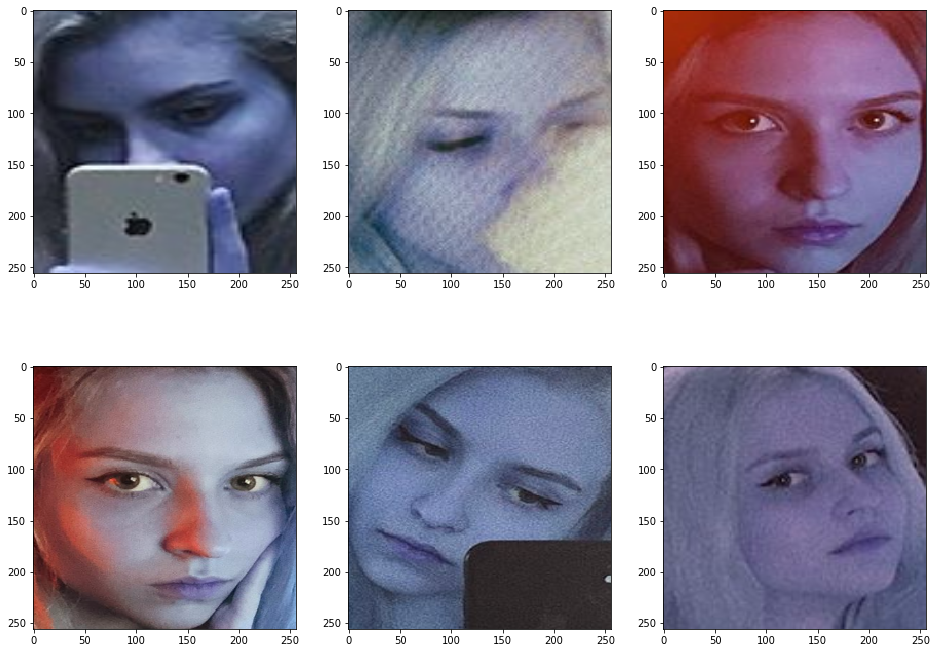

In [52]:
fig, axes = plt.subplots(2, 3, figsize=(16, 12))
axes[0,0].imshow(img_list[0])
axes[0,1].imshow(img_list[1])
axes[0,2].imshow(img_list[2])
axes[1,0].imshow(img_list[3])
axes[1,1].imshow(img_list[4])
axes[1,2].imshow(img_list[5])